# (ALT) Google Maps Visualization

In [1]:
import gmplot 

gmap3 = gmplot.GoogleMapPlotter( 41.148522, -8.585676, 15) 
  
# trip0
latitude_list0 = [41.148522, 41.148639, 41.148855, 41.148927, 41.148963 , 41.148954, 41.14872, 41.147847, 41.14746, 41.147154, 41.146623] 
longitude_list0 = [ -8.585676, -8.585712, -8.585685, -8.58573 , -8.585982, -8.586396, -8.586072, -8.586324, -8.586999, -8.586576, -8.584884 ] 
gmap3.scatter( latitude_list0, longitude_list0, '# FF0000', size = 2.5, marker = False ) 
gmap3.plot(latitude_list0, longitude_list0, 'cornflowerblue', edge_width = 2.5) 
  
gmap3.draw( "map.html" )

# 0. Import Data

In [1]:
import csv
import math
import mplleaflet
import matplotlib.pyplot as plt
import pandas as pd
import gps_utils as gps

In [2]:
with open('../test.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')

    latitude_list = []
    longitude_list = []
    time_list = []
    # breaks only for development purposes
    counter = 0
    time = 0
    
    # for development only
    # test ist eine Liste mit allen Trajectories, jeder Traejctory ist ein (Pandas-) Dataframe mit den Spalten lon, lat, time
    test = []
    
    for row in csv_reader:
        cleared = row[8].replace("],[", " -1 ").replace("[[", "").replace("]]", "")
        if cleared != "POLYLINE":
            splitted = cleared.split(" -1 ")
            # extractes all the points
            for entry in splitted:
                data = entry.split(",")
                latitude_list.append(data[1])
                longitude_list.append(data[0])
                time_list.append(time)
                time += 15
            counter += 1
            time = 0
            # creats a trajectory dataframe
            coords = pd.DataFrame({'lon': longitude_list, 'lat': latitude_list, 'time': time_list})
            test.append(coords)
            # reset everything 
            latitude_list = []
            longitude_list = []
            time_list = []
            # breaks only for development purposes
            if counter == 6:
                break

# 1. Initial Data 

In [3]:
# retrieve the test route
coords = test[5]
coords.lon = coords.lon.astype(float)
coords.lat = coords.lat.astype(float)

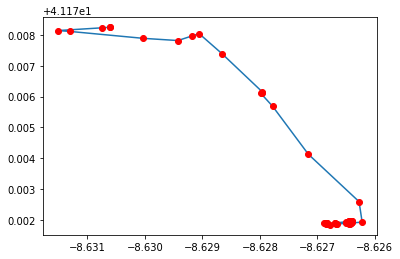

In [4]:
fig = plt.figure()
simplified_coords = coords[['lon', 'lat']].values
plt.plot(simplified_coords[:,0], simplified_coords[:,1])
plt.plot(simplified_coords[:,0], simplified_coords[:,1], 'ro')

In [5]:
mplleaflet.display(fig=fig)

/Users/jiafug/.conda/envs/DBPRO/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


# 2. Trajectory Partition

## 2.1. Stop Point Extraction (TDBC)
Referenz: Z. Fu, Z. Tian, Y. Xu, and C. Qiao, ‘‘A two-step clustering approach to extract locations from individual GPS trajectory data,’’ ISPRS Int. J. Geo- Inf., vol. 5, no. 10, p. 166, 2016.

Auch bei Github hochgeladen als spe-tdbc.pdf
### note: currently not working as indented
#### die Funktion stop_point_extraction() muss nur noch gefixt werden

In [7]:
print(gps.centroid(coords['lon'].tolist(), coords['lat'].tolist()))

(-8.626792113822455, 41.172497610195045)


In [6]:
def centroid(lonT, latT):
    # https://stackoverflow.com/questions/6671183/calculate-the-center-point-of-multiple-latitude-longitude-coordinate-pairs

    # lonT = [13.341664, 13.374373, 13.376003, 13.352830]
    # latT = [52.519198, 52.523039, 52.504053, 52.508498]
    
    if (len(lonT) == 0 or len(latT)== 0):
        return 0, 0

    xList = []
    yList = []
    zList = []

    dataT = pd.DataFrame({'lat': latT, 'lon': lonT})
    for index, row in dataT.iterrows():
        lat = row['lat'] * math.pi / 180
        lon = row['lon'] * math.pi / 180
        X = math.cos(lat) * math.cos(lon)
        Y = math.cos(lat) * math.sin(lon)
        Z = math.sin(lat)
        xList.append(X)
        yList.append(Y)
        zList.append(Z)

    dataXYZ = pd.DataFrame({'x': xList, 'y': yList, 'z': zList})

    x = 0
    y = 0
    z = 0
    n = 0

    for index, row in dataXYZ.iterrows():
        x += row['x']
        y += row['y']
        z += row['z']
        n += 1

    aX = x / n
    aY = y / n
    aZ = z / n

    Lon = math.atan2(y, x) * 180 / math.pi
    Hyp = math.sqrt(x * x + y * y)
    Lat = math.atan2(z, Hyp) * 180 / math.pi

    return Lon, Lat

In [7]:
def stop_point_extraction(trajectory, time_threshold, distance_threshold):

    # leere Cluster, c_cluster ist Cluster aus dem Paper, p_cluster ist Previous C
    c_cluster = pd.DataFrame(columns=['lon','lat','time'])
    p_cluster = pd.DataFrame(columns=['lon','lat','time'])
    stop_points = pd.DataFrame(columns=['lon','lat','time'])
    stop_points_cluster = pd.DataFrame(columns=['lon','lat','tstart', 'tend'])
    # p_point ist Previous stop point in SP aus dem Paper, relevant für Zeile 9 und 11 aus dem Paper
    p_point = None
    # Boolean Flag, nur relevant für die check Funktion
    is_type2 = False
    # braucht man nicht wirklich
    counter = 0     
    
    def start_end(cluster):
        min_time = min(cluster['time'].tolist())
        max_time = max(cluster['time'].tolist())
        return min_time, max_time
    
    def add_stop_point(cluster):
        print("-------------------BEGIN: add_stop_point(cluster)---------------------")
        # nonlocal, damit auf die Variablen der übergeordneten Funktion aufgerufen und bearbeiten werden kann
        nonlocal p_cluster
        nonlocal stop_points
        nonlocal stop_points_cluster
        nonlocal c_cluster
        # Variablen Initialisierung 
        p_stop_point = None
        # Nur relevant für die Initailisierung des Algorithmuses: wenn kein Stopppunkt vorhanden,
        # füge das aktuelle Cluster oder Punkt der Liste der Stopppunkte hinzu
        print("-> cluster:")
        print(cluster)
        min_time, max_time = start_end(cluster)
        if len(stop_points.tail(1)['lon'].values) == 0:
            stop_points = stop_points.append(cluster, ignore_index=True)
            stop_points_cluster = stop_points_cluster.append(cluster, ignore_index=True)
            p_cluster = cluster
            print("--> initial SP")
            print("-> stop_points:")
            print(stop_points)
            print("-> stop_points_cluster:")
            print(stop_points_cluster)
        else:
            p_stop_point = stop_points_cluster.tail(1)['lon'].values[0], stop_points_cluster.tail(1)['lat'].values[0]
            cluster_coord = centroid(cluster['lon'].tolist(), cluster['lat'].tolist())
            # gps.haversine(coord1, coord2) berechnet die Distanc in Metern zwischen zwei Koordinaten
            # coord1 und coord2 müssen als Dataframe mit den Spalten lon und lat vorliegen
            print("-> p_stop_point")
            print(p_stop_point)
            print("-> cluster")
            print(cluster_coord)
            print("-> distance between cluster and p_stop_point")
            print(gps.haversine(cluster_coord, p_stop_point))
            if gps.haversine(cluster_coord, p_stop_point) < distance_threshold:
                # hängt alle Punkte des Clusters oder einzelnen Punkt an den p_cluster (vorheriger Cluster)
                p_stop_point_lon, p_stop_point_lat = p_stop_point
                test_point = centroid([p_stop_point_lon], [p_stop_point_lon])
                test_point_frame = pd.DataFrame({"lon": [p_stop_point_lon], "lat": [p_stop_point_lat], "tstart": [min_time], "tend": [max_time]})
                stop_points = pd.concat([stop_points,cluster]).drop_duplicates().reset_index(drop=True)
                stop_points_cluster = stop_points_cluster.drop(stop_points_cluster.tail(1).index, inplace = True)
                stop_points_cluster = pd.concat([stop_points_cluster,test_point_frame]).drop_duplicates().reset_index(drop=True)
                print("--> Added c_cluster to p_cluster!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
                print("-> c_cluster:")
                print(c_cluster)
                print("-> p_cluster:")
                print(p_cluster)
                c_cluster = c_cluster.iloc[0:0]
            else:
                centeroid_lon, centeroid_lat = cluster_coord
                if centeroid_lon != 0:
                    data = {'lon': [centeroid_lon], 'lat': [centeroid_lat], 'tstart': [min_time], 'tend': [max_time]}
                    sp_frame = pd.DataFrame(data, columns=['lon', 'lat', 'tstart', 'tend'])
                    stop_points = stop_points.append(cluster, ignore_index=True)
                    stop_points_cluster = stop_points_cluster.append(sp_frame, ignore_index=True)
                    p_cluster = cluster
                    # Dataframe.iloc[0:0] löscht den Inhalt eines Dataframes, hier den Inhalt von c_cluster
                    c_cluster = c_cluster.iloc[0:0]
                    print("---> p_cluster = cluster / drop c_cluster")
            print("-> stop_points:")
            print(stop_points)
            print("-> stop_points_cluster:")
            print(stop_points_cluster)
        print("-------------------END: add_stop_point(cluster)---------------------")

            
    def check():
        print("-------------------BEGIN: check()---------------------")
        nonlocal c_cluster
        nonlocal p_cluster
        nonlocal is_type2
        # centroid(coods, coords) berechnet den Mittelpunkt, Argumente, sind jeweils eine Liste von lon und lat
        c_cluster_coord = centroid(c_cluster['lon'].tolist(), c_cluster['lat'].tolist())
        p_cluster_coord = centroid(p_cluster['lon'].tolist(), p_cluster['lat'].tolist())
        print("---> BEFORE:")
        print("-> c_cluster:")
        print(c_cluster)
        print("-> p_cluster:")
        print(p_cluster)
        print("-> time_interval:")
        print(time_interval())
        print("-> distance c_cluster_coord, p_cluster_coord:")
        print(gps.haversine(c_cluster_coord, p_cluster_coord))
        if (time_interval() < time_threshold and gps.haversine(c_cluster_coord, p_cluster_coord) < distance_threshold):
            # p_cluster wird erweitert mit c_cluster, Duplikate werden gelöscht
            p_cluster = p_cluster.append(c_cluster).drop_duplicates().reset_index(drop=True)
            print("-> p_cluster")
            print(p_cluster)
            print("-> is_type2")
            print(is_type2)
            if is_type2 == True:
                print("----> add_stop_point(p_cluster)")
                add_stop_point(p_cluster)
                is_type2 == False
                # c_cluster = c_cluster.iloc[0:0]
            else:
                print("----> p_cluster = c_cluster / drop c_cluster")
                p_cluster = c_cluster
                # löschen des Inhalts von c_cluster
                # c_cluster = c_cluster.iloc[0:0]
        else:
            # pass
            add_stop_point(c_cluster)
        print("---> AFTER:")
        print("-> c_cluster:")
        print(c_cluster)
        print("-> p_cluster:")
        print(p_cluster)
        print("-------------------END: check()---------------------")
            
    def time_interval():
        nonlocal c_cluster
        nonlocal p_cluster
        # wenn p_cluster leer, dann return 0 als Zeitinterval
        if p_cluster.shape[0] == 0:
            return 0
        # berechnet den Zeitinterval von zwei Clustern, indem der Maximalwert (Zeit) der beiden Cluster - Minimalwert
        min_time = min([c_cluster.iloc[[0]]['time'].tolist()[0], p_cluster.iloc[[0]]['time'].tolist()[0]])
        max_time = max([c_cluster.iloc[[-1]]['time'].tolist()[0], p_cluster.iloc[[-1]]['time'].tolist()[0]])
        return abs(max_time - min_time)
    
    def duration():
        nonlocal c_cluster
        min_time = min(c_cluster['time'].tolist())
        max_time = max(c_cluster['time'].tolist())
        return max_time - min_time
    
    p_coord = None
    skip = False
    # adds the first and last trajectory points as type 1 stop points 
    # if counter == 0 or counter == trajectory.shape[0]-1:
    
    first_sp_lon = trajectory.iloc[0].values[0]
    first_sp_lat = trajectory.iloc[0].values[1]
    first_sp_frame = pd.DataFrame({"lon": [first_sp_lon], "lat": [first_sp_lat], "time": [0]})
    print(first_sp_frame)
    add_stop_point(first_sp_frame)
    for index, point in trajectory.iterrows():
        point_coord = point['lon'], point['lat']
        point_frame = pd.DataFrame({"lon": [point['lon']], "lat": [point['lat']], "time": [point['time']]})
        print("_____________________________________________________________________________")
        print("-> p_coord:")
        print(p_coord)
        print("-> point_coord:")
        print(point_coord)
        if p_coord != None:
            print("-> distance between p_coord and point_coord:")
            print(gps.haversine(p_coord, point_coord))
        # Lösungsvorschlag, wenn der initiale Cluster leer ist, dann füge aktuellen Punkt hinzu
        cluster_coord = centroid(c_cluster['lon'].tolist(), c_cluster['lat'].tolist())
        #print(gps.haversine(cluster_coord, point_coord))
        #print(cluster_coord, point_coord)
        # Punkte des Typ 2 sind der 1,2,3 Fall
        if c_cluster.shape[0] == 0:
            print("IF -> Cluster empty")
            if p_coord != None and gps.haversine(p_coord, point_coord) < distance_threshold:
                print("----->c_cluster empty: put current point in c_cluster")
                p_p_lon, p_p_lat = p_coord
                p_point_frame = pd.DataFrame({"lon": [p_p_lon], "lat": [p_p_lat], "time": [point['time']-15]})
                # if (point['time'] - 15) != 0 :
                c_cluster = c_cluster.append(p_point_frame)
                c_cluster = c_cluster.append(point_frame)
                cluster_coord = centroid(c_cluster['lon'].tolist(), c_cluster['lat'].tolist())
            else:
                skip = True
                print("----->PASS -> p_coord None or distance between p_coord, point_coord < distance_threshold")
        
        else:
            skip = False
            print("ELSE -> Cluster not empty and point may be added to cluster")
            if gps.haversine(cluster_coord, point_coord) < distance_threshold:
                print(">>>case1: put in c_cluster")
                c_cluster = c_cluster.append(point_frame)
                cluster_coord = centroid(c_cluster['lon'].tolist(), c_cluster['lat'].tolist())
                is_type2 = True
        if (skip != True):
            print("Other Cases:")
            print("-> distance cluster_coord and point_coord")
            print(gps.haversine(cluster_coord, point_coord))
            print("-> duration()")
            print(duration())
            if c_cluster.shape[0] != 0 and gps.haversine(cluster_coord, point_coord) > distance_threshold and duration() > time_threshold:
                print(">>>case2")
                add_stop_point(c_cluster) 
                is_type2 = True
            if c_cluster.shape[0] != 0 and gps.haversine(cluster_coord, point_coord) > distance_threshold and duration() < time_threshold:
                print(">>>case3")
                check()
                is_type2 = True
            if p_coord != None and gps.haversine(p_coord, point_coord) < distance_threshold and 15 > time_threshold:
                print(">>>case4")
                is_type2 = False
                
            if p_coord != None and gps.haversine(p_coord, point_coord) > distance_threshold and 15 > time_threshold:
                print(">>>case5")
                is_type2 = False
                pass
        print("<<<----------LOOP RESULTS BEGINN---------->>>")
        print("-> c_cluster")
        print(c_cluster)
        print("-> p_cluster")
        print(p_cluster)
        print("-> END: stop_points")
        print(stop_points)
        print("-> END: stop_points_cluster")
        print(stop_points_cluster)
        print("<<<----------LOOP RESULTS END---------->>>")
        
        counter += 1
        # p_coord (Vorherige Punkt) wird gesetzt
        p_coord = point['lon'], point['lat']
    cluster_coord = centroid(c_cluster['lon'].tolist(), c_cluster['lat'].tolist())
    centeroid_lon, centeroid_lat = cluster_coord
    min_time, max_time = start_end(c_cluster)
    data = {'lon': [centeroid_lon], 'lat': [centeroid_lat], 'tstart': [min_time], 'tend': [max_time]}
    sp_frame = pd.DataFrame(data, columns=['lon', 'lat', 'tstart', 'tend'])
    stop_points_cluster = stop_points_cluster.append(sp_frame, ignore_index=True)
    stop_points = stop_points.append(c_cluster, ignore_index=True)
    print("ENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDEND")
    print(stop_points_cluster)
    

    return stop_points, stop_points_cluster


## Test Route: this cell below is a custom test route
The data is safed in the variable df

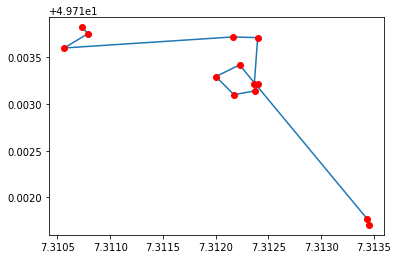

In [11]:
lon_test_list = [7.310735, 7.310789, 7.310564, 7.312163, 7.312399, 7.312367, 7.312399, 7.312378, 7.312174, 7.312002, 7.312227, 7.313439, 7.313450]
lat_test_list = [49.713822, 49.713753, 49.713600, 49.713718, 49.713711, 49.713218, 49.713211, 49.713142, 49.713100, 49.713294, 49.713419, 49.711768, 49.711706]
time_test_list = [0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180] 
data = {'lon': lon_test_list,
        'lat': lat_test_list,
        'time': time_test_list}
df = pd.DataFrame(data, columns=['lon', 'lat', 'time'])
test_polt_data = df[['lon', 'lat']].values
plt.plot(test_polt_data[:,0], test_polt_data[:,1])
plt.plot(test_polt_data[:,0], test_polt_data[:,1], 'ro')


In [8]:
time_threshold = 500
distance_threshold = 60
stop_points, stop_points_cluster = stop_point_extraction(coords, time_threshold, distance_threshold)

        lon        lat  time
0 -8.630613  41.178249     0
-------------------BEGIN: add_stop_point(cluster)---------------------
-> cluster:
        lon        lat  time
0 -8.630613  41.178249     0
--> initial SP
-> stop_points:
        lon        lat time
0 -8.630613  41.178249    0
-> stop_points_cluster:
         lat       lon tend  time tstart
0  41.178249 -8.630613  NaN   0.0    NaN
-------------------END: add_stop_point(cluster)---------------------
_____________________________________________________________________________
-> p_coord:
None
-> point_coord:
(-8.630613, 41.178249)
IF -> Cluster empty
----->PASS -> p_coord None or distance between p_coord, point_coord < distance_threshold
<<<----------LOOP RESULTS BEGINN---------->>>
-> c_cluster
Empty DataFrame
Columns: [lon, lat, time]
Index: []
-> p_cluster
        lon        lat  time
0 -8.630613  41.178249     0
-> END: stop_points
        lon        lat time
0 -8.630613  41.178249    0
-> END: stop_points_cluster
         l

/Users/jiafug/.conda/envs/DBPRO/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Empty DataFrame
Columns: [lon, lat, time]
Index: []
-> p_cluster:
        lon        lat   time
0 -8.630028  41.177889   75.0
0 -8.629425  41.177817   90.0
0 -8.629173  41.177970  105.0
0 -8.629056  41.178042  120.0
-------------------END: check()---------------------
<<<----------LOOP RESULTS BEGINN---------->>>
-> c_cluster
Empty DataFrame
Columns: [lon, lat, time]
Index: []
-> p_cluster
        lon        lat   time
0 -8.630028  41.177889   75.0
0 -8.629425  41.177817   90.0
0 -8.629173  41.177970  105.0
0 -8.629056  41.178042  120.0
-> END: stop_points
        lon        lat time
0 -8.630613  41.178249    0
1 -8.630613  41.178249   15
2 -8.630739  41.178231   30
3 -8.631513  41.178141   45
4 -8.631306  41.178114   60
5 -8.630028  41.177889   75
6 -8.629425  41.177817   90
7 -8.629173  41.177970  105
8 -8.629056  41.178042  120
-> END: stop_points_cluster
        lon        lat  tstart   tend
0 -8.630613  41.178249     0.0   30.0
1 -8.631409  41.178128    45.0   60.0
2 -8.629421  41

        lon        lat   time
0 -8.627958  41.176152  150.0
0 -8.627967  41.176125  165.0
0 -8.627985  41.176107  180.0
0 -8.627778  41.175684  195.0
-> END: stop_points
         lon        lat time
0  -8.630613  41.178249    0
1  -8.630613  41.178249   15
2  -8.630739  41.178231   30
3  -8.631513  41.178141   45
4  -8.631306  41.178114   60
5  -8.630028  41.177889   75
6  -8.629425  41.177817   90
7  -8.629173  41.177970  105
8  -8.629056  41.178042  120
9  -8.627958  41.176152  150
10 -8.627967  41.176125  165
11 -8.627985  41.176107  180
12 -8.627778  41.175684  195
-> END: stop_points_cluster
        lon        lat  tstart   tend
0 -8.630613  41.178249     0.0   30.0
1 -8.631409  41.178128    45.0   60.0
2 -8.629421  41.177930    75.0  120.0
3 -8.627922  41.176017   150.0  195.0
<<<----------LOOP RESULTS END---------->>>
_____________________________________________________________________________
-> p_coord:
(-8.62641, 41.171922)
-> point_coord:
(-8.626401, 41.171922)
-> distance 

ELSE -> Cluster not empty and point may be added to cluster
>>>case1: put in c_cluster
Other Cases:
-> distance cluster_coord and point_coord
1.251459558360299
-> duration()
285.0
<<<----------LOOP RESULTS BEGINN---------->>>
-> c_cluster
        lon        lat   time
0 -8.626221  41.171922  240.0
0 -8.626419  41.171895  255.0
0 -8.626419  41.171904  270.0
0 -8.626428  41.171913  285.0
0 -8.626428  41.171913  300.0
0 -8.626419  41.171913  315.0
0 -8.626410  41.171922  330.0
0 -8.626401  41.171922  345.0
0 -8.626410  41.171931  360.0
0 -8.626410  41.171931  375.0
0 -8.626419  41.171931  390.0
0 -8.626419  41.171922  405.0
0 -8.626419  41.171922  420.0
0 -8.626419  41.171913  435.0
0 -8.626437  41.171913  450.0
0 -8.626446  41.171922  465.0
0 -8.626446  41.171913  480.0
0 -8.626446  41.171913  495.0
0 -8.626437  41.171913  510.0
0 -8.626428  41.171913  525.0
-> p_cluster
        lon        lat   time
0 -8.627958  41.176152  150.0
0 -8.627967  41.176125  165.0
0 -8.627985  41.176107  180.

        lon        lat   time
0 -8.626221  41.171922  240.0
0 -8.626419  41.171895  255.0
0 -8.626419  41.171904  270.0
0 -8.626428  41.171913  285.0
0 -8.626428  41.171913  300.0
0 -8.626419  41.171913  315.0
0 -8.626410  41.171922  330.0
0 -8.626401  41.171922  345.0
0 -8.626410  41.171931  360.0
0 -8.626410  41.171931  375.0
0 -8.626419  41.171931  390.0
0 -8.626419  41.171922  405.0
0 -8.626419  41.171922  420.0
0 -8.626419  41.171913  435.0
0 -8.626437  41.171913  450.0
0 -8.626446  41.171922  465.0
0 -8.626446  41.171913  480.0
0 -8.626446  41.171913  495.0
0 -8.626437  41.171913  510.0
0 -8.626428  41.171913  525.0
0 -8.626437  41.171913  540.0
0 -8.626437  41.171904  555.0
0 -8.626437  41.171904  570.0
0 -8.626428  41.171913  585.0
0 -8.626428  41.171904  600.0
0 -8.626437  41.171895  615.0
0 -8.626446  41.171895  630.0
0 -8.626446  41.171886  645.0
0 -8.626446  41.171886  660.0
0 -8.626437  41.171886  675.0
-> p_cluster
        lon        lat   time
0 -8.627958  41.176152  150

        lon        lat   time
0 -8.626221  41.171922  240.0
0 -8.626419  41.171895  255.0
0 -8.626419  41.171904  270.0
0 -8.626428  41.171913  285.0
0 -8.626428  41.171913  300.0
0 -8.626419  41.171913  315.0
0 -8.626410  41.171922  330.0
0 -8.626401  41.171922  345.0
0 -8.626410  41.171931  360.0
0 -8.626410  41.171931  375.0
0 -8.626419  41.171931  390.0
0 -8.626419  41.171922  405.0
0 -8.626419  41.171922  420.0
0 -8.626419  41.171913  435.0
0 -8.626437  41.171913  450.0
0 -8.626446  41.171922  465.0
0 -8.626446  41.171913  480.0
0 -8.626446  41.171913  495.0
0 -8.626437  41.171913  510.0
0 -8.626428  41.171913  525.0
0 -8.626437  41.171913  540.0
0 -8.626437  41.171904  555.0
0 -8.626437  41.171904  570.0
0 -8.626428  41.171913  585.0
0 -8.626428  41.171904  600.0
0 -8.626437  41.171895  615.0
0 -8.626446  41.171895  630.0
0 -8.626446  41.171886  645.0
0 -8.626446  41.171886  660.0
0 -8.626437  41.171886  675.0
0 -8.626437  41.171877  690.0
0 -8.626446  41.171877  705.0
0 -8.62644

3 -8.627922  41.176017   150.0  195.0
<<<----------LOOP RESULTS END---------->>>
_____________________________________________________________________________
-> p_coord:
(-8.626446, 41.171922)
-> point_coord:
(-8.626437, 41.171922)
-> distance between p_coord and point_coord:
0.7533054316133501
ELSE -> Cluster not empty and point may be added to cluster
>>>case1: put in c_cluster
Other Cases:
-> distance cluster_coord and point_coord
1.1776329896002673
-> duration()
720.0
<<<----------LOOP RESULTS BEGINN---------->>>
-> c_cluster
        lon        lat   time
0 -8.626221  41.171922  240.0
0 -8.626419  41.171895  255.0
0 -8.626419  41.171904  270.0
0 -8.626428  41.171913  285.0
0 -8.626428  41.171913  300.0
0 -8.626419  41.171913  315.0
0 -8.626410  41.171922  330.0
0 -8.626401  41.171922  345.0
0 -8.626410  41.171931  360.0
0 -8.626410  41.171931  375.0
0 -8.626419  41.171931  390.0
0 -8.626419  41.171922  405.0
0 -8.626419  41.171922  420.0
0 -8.626419  41.171913  435.0
0 -8.626437  

        lon        lat  tstart   tend
0 -8.630613  41.178249     0.0   30.0
1 -8.631409  41.178128    45.0   60.0
2 -8.629421  41.177930    75.0  120.0
3 -8.627922  41.176017   150.0  195.0
<<<----------LOOP RESULTS END---------->>>
_____________________________________________________________________________
-> p_coord:
(-8.626464, 41.171913)
-> point_coord:
(-8.626464, 41.171904)
-> distance between p_coord and point_coord:
1.0007543404347168
ELSE -> Cluster not empty and point may be added to cluster
>>>case1: put in c_cluster
Other Cases:
-> distance cluster_coord and point_coord
2.562167714400767
-> duration()
825.0
<<<----------LOOP RESULTS BEGINN---------->>>
-> c_cluster
        lon        lat    time
0 -8.626221  41.171922   240.0
0 -8.626419  41.171895   255.0
0 -8.626419  41.171904   270.0
0 -8.626428  41.171913   285.0
0 -8.626428  41.171913   300.0
0 -8.626419  41.171913   315.0
0 -8.626410  41.171922   330.0
0 -8.626401  41.171922   345.0
0 -8.626410  41.171931   360.0
0 

         lon        lat    time
0  -8.626221  41.171922   240.0
0  -8.626419  41.171895   255.0
0  -8.626419  41.171904   270.0
0  -8.626428  41.171913   285.0
0  -8.626428  41.171913   300.0
0  -8.626419  41.171913   315.0
0  -8.626410  41.171922   330.0
0  -8.626401  41.171922   345.0
0  -8.626410  41.171931   360.0
0  -8.626410  41.171931   375.0
0  -8.626419  41.171931   390.0
0  -8.626419  41.171922   405.0
0  -8.626419  41.171922   420.0
0  -8.626419  41.171913   435.0
0  -8.626437  41.171913   450.0
0  -8.626446  41.171922   465.0
0  -8.626446  41.171913   480.0
0  -8.626446  41.171913   495.0
0  -8.626437  41.171913   510.0
0  -8.626428  41.171913   525.0
0  -8.626437  41.171913   540.0
0  -8.626437  41.171904   555.0
0  -8.626437  41.171904   570.0
0  -8.626428  41.171913   585.0
0  -8.626428  41.171904   600.0
0  -8.626437  41.171895   615.0
0  -8.626446  41.171895   630.0
0  -8.626446  41.171886   645.0
0  -8.626446  41.171886   660.0
0  -8.626437  41.171886   675.0
..      

Other Cases:
-> distance cluster_coord and point_coord
2.8119782489909575
-> duration()
1020.0
<<<----------LOOP RESULTS BEGINN---------->>>
-> c_cluster
         lon        lat    time
0  -8.626221  41.171922   240.0
0  -8.626419  41.171895   255.0
0  -8.626419  41.171904   270.0
0  -8.626428  41.171913   285.0
0  -8.626428  41.171913   300.0
0  -8.626419  41.171913   315.0
0  -8.626410  41.171922   330.0
0  -8.626401  41.171922   345.0
0  -8.626410  41.171931   360.0
0  -8.626410  41.171931   375.0
0  -8.626419  41.171931   390.0
0  -8.626419  41.171922   405.0
0  -8.626419  41.171922   420.0
0  -8.626419  41.171913   435.0
0  -8.626437  41.171913   450.0
0  -8.626446  41.171922   465.0
0  -8.626446  41.171913   480.0
0  -8.626446  41.171913   495.0
0  -8.626437  41.171913   510.0
0  -8.626428  41.171913   525.0
0  -8.626437  41.171913   540.0
0  -8.626437  41.171904   555.0
0  -8.626437  41.171904   570.0
0  -8.626428  41.171913   585.0
0  -8.626428  41.171904   600.0
0  -8.626437  

         lon        lat    time
0  -8.626221  41.171922   240.0
0  -8.626419  41.171895   255.0
0  -8.626419  41.171904   270.0
0  -8.626428  41.171913   285.0
0  -8.626428  41.171913   300.0
0  -8.626419  41.171913   315.0
0  -8.626410  41.171922   330.0
0  -8.626401  41.171922   345.0
0  -8.626410  41.171931   360.0
0  -8.626410  41.171931   375.0
0  -8.626419  41.171931   390.0
0  -8.626419  41.171922   405.0
0  -8.626419  41.171922   420.0
0  -8.626419  41.171913   435.0
0  -8.626437  41.171913   450.0
0  -8.626446  41.171922   465.0
0  -8.626446  41.171913   480.0
0  -8.626446  41.171913   495.0
0  -8.626437  41.171913   510.0
0  -8.626428  41.171913   525.0
0  -8.626437  41.171913   540.0
0  -8.626437  41.171904   555.0
0  -8.626437  41.171904   570.0
0  -8.626428  41.171913   585.0
0  -8.626428  41.171904   600.0
0  -8.626437  41.171895   615.0
0  -8.626446  41.171895   630.0
0  -8.626446  41.171886   645.0
0  -8.626446  41.171886   660.0
0  -8.626437  41.171886   675.0
..      

Other Cases:
-> distance cluster_coord and point_coord
2.2543805369104555
-> duration()
1215.0
<<<----------LOOP RESULTS BEGINN---------->>>
-> c_cluster
         lon        lat    time
0  -8.626221  41.171922   240.0
0  -8.626419  41.171895   255.0
0  -8.626419  41.171904   270.0
0  -8.626428  41.171913   285.0
0  -8.626428  41.171913   300.0
0  -8.626419  41.171913   315.0
0  -8.626410  41.171922   330.0
0  -8.626401  41.171922   345.0
0  -8.626410  41.171931   360.0
0  -8.626410  41.171931   375.0
0  -8.626419  41.171931   390.0
0  -8.626419  41.171922   405.0
0  -8.626419  41.171922   420.0
0  -8.626419  41.171913   435.0
0  -8.626437  41.171913   450.0
0  -8.626446  41.171922   465.0
0  -8.626446  41.171913   480.0
0  -8.626446  41.171913   495.0
0  -8.626437  41.171913   510.0
0  -8.626428  41.171913   525.0
0  -8.626437  41.171913   540.0
0  -8.626437  41.171904   555.0
0  -8.626437  41.171904   570.0
0  -8.626428  41.171913   585.0
0  -8.626428  41.171904   600.0
0  -8.626437  

ELSE -> Cluster not empty and point may be added to cluster
>>>case1: put in c_cluster
Other Cases:
-> distance cluster_coord and point_coord
3.5197851622770555
-> duration()
1305.0
<<<----------LOOP RESULTS BEGINN---------->>>
-> c_cluster
         lon        lat    time
0  -8.626221  41.171922   240.0
0  -8.626419  41.171895   255.0
0  -8.626419  41.171904   270.0
0  -8.626428  41.171913   285.0
0  -8.626428  41.171913   300.0
0  -8.626419  41.171913   315.0
0  -8.626410  41.171922   330.0
0  -8.626401  41.171922   345.0
0  -8.626410  41.171931   360.0
0  -8.626410  41.171931   375.0
0  -8.626419  41.171931   390.0
0  -8.626419  41.171922   405.0
0  -8.626419  41.171922   420.0
0  -8.626419  41.171913   435.0
0  -8.626437  41.171913   450.0
0  -8.626446  41.171922   465.0
0  -8.626446  41.171913   480.0
0  -8.626446  41.171913   495.0
0  -8.626437  41.171913   510.0
0  -8.626428  41.171913   525.0
0  -8.626437  41.171913   540.0
0  -8.626437  41.171904   555.0
0  -8.626437  41.171904

        lon        lat  tstart   tend
0 -8.630613  41.178249     0.0   30.0
1 -8.631409  41.178128    45.0   60.0
2 -8.629421  41.177930    75.0  120.0
3 -8.627922  41.176017   150.0  195.0
<<<----------LOOP RESULTS END---------->>>
_____________________________________________________________________________
-> p_coord:
(-8.626689, 41.171895)
-> point_coord:
(-8.626698, 41.171895)
-> distance between p_coord and point_coord:
0.7533057419249014
ELSE -> Cluster not empty and point may be added to cluster
>>>case1: put in c_cluster
Other Cases:
-> distance cluster_coord and point_coord
20.987128919061966
-> duration()
1395.0
<<<----------LOOP RESULTS BEGINN---------->>>
-> c_cluster
         lon        lat    time
0  -8.626221  41.171922   240.0
0  -8.626419  41.171895   255.0
0  -8.626419  41.171904   270.0
0  -8.626428  41.171913   285.0
0  -8.626428  41.171913   300.0
0  -8.626419  41.171913   315.0
0  -8.626410  41.171922   330.0
0  -8.626401  41.171922   345.0
0  -8.626410  41.17193

         lon        lat    time
0  -8.626221  41.171922   240.0
0  -8.626419  41.171895   255.0
0  -8.626419  41.171904   270.0
0  -8.626428  41.171913   285.0
0  -8.626428  41.171913   300.0
0  -8.626419  41.171913   315.0
0  -8.626410  41.171922   330.0
0  -8.626401  41.171922   345.0
0  -8.626410  41.171931   360.0
0  -8.626410  41.171931   375.0
0  -8.626419  41.171931   390.0
0  -8.626419  41.171922   405.0
0  -8.626419  41.171922   420.0
0  -8.626419  41.171913   435.0
0  -8.626437  41.171913   450.0
0  -8.626446  41.171922   465.0
0  -8.626446  41.171913   480.0
0  -8.626446  41.171913   495.0
0  -8.626437  41.171913   510.0
0  -8.626428  41.171913   525.0
0  -8.626437  41.171913   540.0
0  -8.626437  41.171904   555.0
0  -8.626437  41.171904   570.0
0  -8.626428  41.171913   585.0
0  -8.626428  41.171904   600.0
0  -8.626437  41.171895   615.0
0  -8.626446  41.171895   630.0
0  -8.626446  41.171886   645.0
0  -8.626446  41.171886   660.0
0  -8.626437  41.171886   675.0
..      

         lon        lat    time
0  -8.626221  41.171922   240.0
0  -8.626419  41.171895   255.0
0  -8.626419  41.171904   270.0
0  -8.626428  41.171913   285.0
0  -8.626428  41.171913   300.0
0  -8.626419  41.171913   315.0
0  -8.626410  41.171922   330.0
0  -8.626401  41.171922   345.0
0  -8.626410  41.171931   360.0
0  -8.626410  41.171931   375.0
0  -8.626419  41.171931   390.0
0  -8.626419  41.171922   405.0
0  -8.626419  41.171922   420.0
0  -8.626419  41.171913   435.0
0  -8.626437  41.171913   450.0
0  -8.626446  41.171922   465.0
0  -8.626446  41.171913   480.0
0  -8.626446  41.171913   495.0
0  -8.626437  41.171913   510.0
0  -8.626428  41.171913   525.0
0  -8.626437  41.171913   540.0
0  -8.626437  41.171904   555.0
0  -8.626437  41.171904   570.0
0  -8.626428  41.171913   585.0
0  -8.626428  41.171904   600.0
0  -8.626437  41.171895   615.0
0  -8.626446  41.171895   630.0
0  -8.626446  41.171886   645.0
0  -8.626446  41.171886   660.0
0  -8.626437  41.171886   675.0
..      

ELSE -> Cluster not empty and point may be added to cluster
>>>case1: put in c_cluster
Other Cases:
-> distance cluster_coord and point_coord
5.036293434052726
-> duration()
1650.0
<<<----------LOOP RESULTS BEGINN---------->>>
-> c_cluster
         lon        lat    time
0  -8.626221  41.171922   240.0
0  -8.626419  41.171895   255.0
0  -8.626419  41.171904   270.0
0  -8.626428  41.171913   285.0
0  -8.626428  41.171913   300.0
0  -8.626419  41.171913   315.0
0  -8.626410  41.171922   330.0
0  -8.626401  41.171922   345.0
0  -8.626410  41.171931   360.0
0  -8.626410  41.171931   375.0
0  -8.626419  41.171931   390.0
0  -8.626419  41.171922   405.0
0  -8.626419  41.171922   420.0
0  -8.626419  41.171913   435.0
0  -8.626437  41.171913   450.0
0  -8.626446  41.171922   465.0
0  -8.626446  41.171913   480.0
0  -8.626446  41.171913   495.0
0  -8.626437  41.171913   510.0
0  -8.626428  41.171913   525.0
0  -8.626437  41.171913   540.0
0  -8.626437  41.171904   555.0
0  -8.626437  41.171904 

Other Cases:
-> distance cluster_coord and point_coord
5.572244002163448
-> duration()
1710.0
<<<----------LOOP RESULTS BEGINN---------->>>
-> c_cluster
         lon        lat    time
0  -8.626221  41.171922   240.0
0  -8.626419  41.171895   255.0
0  -8.626419  41.171904   270.0
0  -8.626428  41.171913   285.0
0  -8.626428  41.171913   300.0
0  -8.626419  41.171913   315.0
0  -8.626410  41.171922   330.0
0  -8.626401  41.171922   345.0
0  -8.626410  41.171931   360.0
0  -8.626410  41.171931   375.0
0  -8.626419  41.171931   390.0
0  -8.626419  41.171922   405.0
0  -8.626419  41.171922   420.0
0  -8.626419  41.171913   435.0
0  -8.626437  41.171913   450.0
0  -8.626446  41.171922   465.0
0  -8.626446  41.171913   480.0
0  -8.626446  41.171913   495.0
0  -8.626437  41.171913   510.0
0  -8.626428  41.171913   525.0
0  -8.626437  41.171913   540.0
0  -8.626437  41.171904   555.0
0  -8.626437  41.171904   570.0
0  -8.626428  41.171913   585.0
0  -8.626428  41.171904   600.0
0  -8.626437  4

ELSE -> Cluster not empty and point may be added to cluster
>>>case1: put in c_cluster
Other Cases:
-> distance cluster_coord and point_coord
9.209896704571191
-> duration()
1785.0
<<<----------LOOP RESULTS BEGINN---------->>>
-> c_cluster
         lon        lat    time
0  -8.626221  41.171922   240.0
0  -8.626419  41.171895   255.0
0  -8.626419  41.171904   270.0
0  -8.626428  41.171913   285.0
0  -8.626428  41.171913   300.0
0  -8.626419  41.171913   315.0
0  -8.626410  41.171922   330.0
0  -8.626401  41.171922   345.0
0  -8.626410  41.171931   360.0
0  -8.626410  41.171931   375.0
0  -8.626419  41.171931   390.0
0  -8.626419  41.171922   405.0
0  -8.626419  41.171922   420.0
0  -8.626419  41.171913   435.0
0  -8.626437  41.171913   450.0
0  -8.626446  41.171922   465.0
0  -8.626446  41.171913   480.0
0  -8.626446  41.171913   495.0
0  -8.626437  41.171913   510.0
0  -8.626428  41.171913   525.0
0  -8.626437  41.171913   540.0
0  -8.626437  41.171904   555.0
0  -8.626437  41.171904 

        lon        lat  tstart    tend
0 -8.630613  41.178249     0.0    30.0
1 -8.631409  41.178128    45.0    60.0
2 -8.629421  41.177930    75.0   120.0
3 -8.628660  41.177394   135.0     NaN
4 -8.627922  41.176017   150.0   195.0
5 -8.627157  41.174127   210.0     NaN
6 -8.626275  41.172588   225.0     NaN
7 -8.626482  41.171912   240.0  2040.0


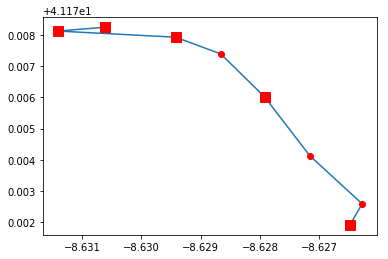

In [9]:
new = coords.merge(stop_points,on=['lon','lat'],how='left')
new = new[new.time_y.isnull()]
new = new.rename(columns={"time_x": "tstart", "time_y": "tend"})
route = stop_points_cluster.append(new)
route = route.sort_values(by=['tstart']).reset_index(drop=True)
print(route)
polt_point_data = route[['lon', 'lat']].values
polt_stop_point_data = stop_points_cluster[['lon', 'lat']].values
plt.plot(polt_point_data[:,0], polt_point_data[:,1])
plt.plot(polt_point_data[:,0], polt_point_data[:,1], 'ro')
plt.plot(polt_stop_point_data[:,0], polt_stop_point_data[:,1], 's', color='red', markersize= 10)

## 2.2. Prototype (einfacher Algorithmus)

In [6]:
coord1 = None
coord2 = None
counter = 0
points = coords.shape[0]
c_cluster = pd.DataFrame(columns=['lon','lat','time'])
p_cluster = pd.DataFrame(columns=['lon','lat','time'])
for index, row in coords.iterrows():
    coord2 = row['lat'], row['lon']
    time2 = row['time']
    if coord1 != None and gps.haversine(coord1, coord2) < 60:
        coords.drop(coords.index[[index-counter,index-counter]], inplace=True)
        counter += 1
    coord1 = row['lat'], row['lon']
    time1 = row['time']
print("{} gps points simplified to {} points".format(points, coords.shape[0]))


137 gps points simplified to 9 points


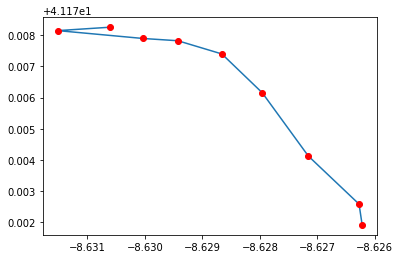

In [7]:
fig = plt.figure()
simplified_coords = coords[['lon', 'lat']].values
plt.plot(simplified_coords[:,0], simplified_coords[:,1])
plt.plot(simplified_coords[:,0], simplified_coords[:,1], 'ro')

In [8]:
mplleaflet.display(fig=fig)

# 3. Data Simplification 

In [32]:
part = []
simplified_coords = pd.DataFrame(columns=['lon','lat','tstart', 'tend'])
for index, point in route.iterrows():
    current_point = [point['lon'], point['lat']]
    part.append(current_point)
    if not math.isnan(point['tend']):
        l_data = gps.rdp(part, 0.00025)
        for i in l_data:
            l_lon = i[0]
            l_lat = i[1]
            l_frame = pd.DataFrame({"lon": [l_lon], "lat": [l_lat]})
            simplified_coords = simplified_coords.append(l_frame)
        part = []
        part.append(current_point)
simplified_coords = simplified_coords.drop_duplicates(subset=None, keep='first', inplace=False).reset_index(drop=True)
merged = route.merge(simplified_coords, on=['lon','lat'])
merged = merged.drop(['tstart_y', 'tend_y'], axis=1)
merged = merged.rename(columns={'tstart_x': 'tstart', 'tend_x': 'tend'})
print(merged)
print("{} gps points simplified to {} points".format(route.shape[0], simplified_coords.shape[0]))

        lon        lat  tstart    tend
0 -8.630613  41.178249     0.0    30.0
1 -8.631409  41.178128    45.0    60.0
2 -8.629421  41.177930    75.0   120.0
3 -8.628660  41.177394   135.0     NaN
4 -8.627922  41.176017   150.0   195.0
5 -8.626275  41.172588   225.0     NaN
6 -8.626482  41.171912   240.0  2040.0
8 gps points simplified to 7 points


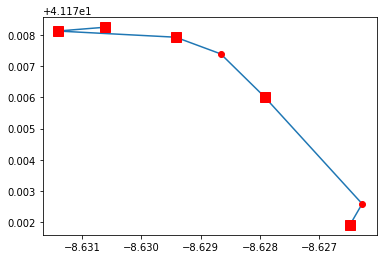

In [19]:
fig = plt.figure()
simplified_coords_plot = simplified_coords[['lon', 'lat']].values
plt.plot(simplified_coords_plot[:,0], simplified_coords_plot[:,1])
plt.plot(simplified_coords_plot[:,0], simplified_coords_plot[:,1], 'ro')
plt.plot(polt_stop_point_data[:,0], polt_stop_point_data[:,1], 's', color='red', markersize= 10)

In [38]:
mplleaflet.display(fig=fig)